In [104]:
# Base imports
import os
import sqlite3
import itertools
from collections import Counter

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import shifterator as sh

# Model preprocessing
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix

For this project we are looking at bill summary data from the 114th-117th Congress. We aim to be able to classify bills as either 'democrat' or 'republica' given just the bill summary data, which can be found on congress.gov. All data was scraped directly from congress' website.

In [2]:
# Change directory
os.chdir('data/')

# Load data
conn = sqlite3.connect('congress.db')
congress = pd.read_sql_query("SELECT * FROM congress", conn)
conn.close()

congress.head()

,congress,hr_measure,sponsor_name,sponsor_party,bill_name,bill_summary
0,117,1,Sarbanes John P,D,For the People Act of 2021,"This bill addresses voter access, election int..."
1,117,3,Pallone Frank Jr,D,Elijah E. Cummings Lower Drug Costs Now Act,This bill establishes several programs and req...
2,117,4,Sewell Terri A,D,John R. Lewis Voting Rights Advancement Act of...,This bill establishes new criteria for determi...
3,117,5,Cicilline David N,D,Equality Act,This bill prohibits discrimination based on se...
4,117,6,Roybal-Allard Lucille,D,None,American Dream and Promise Act of 2021 This bi...


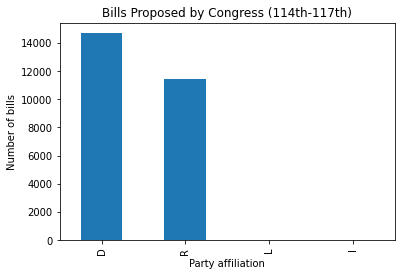

In [3]:
plt.title("Bills Proposed by Congress (114th-117th)")
congress['sponsor_party'].value_counts().plot(kind='bar')
plt.ylabel("Number of bills")
plt.xlabel("Party affiliation")
plt.show();

In [4]:
congress['sponsor_party'].value_counts()

D    14705
R    11446
L        7
I        2
Name: sponsor_party, dtype: int64

From here we can see that there is a slight skew in our data, although not terrible, roughly 56% of the bills have been proposed by democrats versus 44% which have been proposed by republicans. Since libertarian (L) and independent (I) make up such a small sample of our total data, we will remove them and focus solely on democrats and republicans.

In [5]:
# Filter data for only democrate and republican
dem = congress[congress['sponsor_party'] == 'D']
rep = congress[congress['sponsor_party'] == 'R']

Now we can begin to do some simple exploratory data analysis. We'll start by looking just at the frequency of words used in each bill.

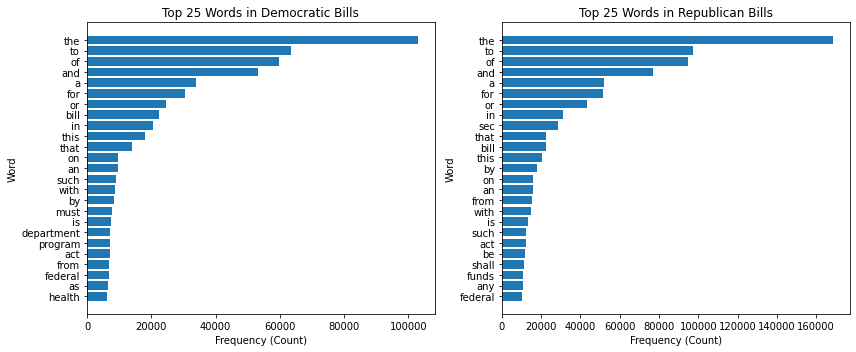

In [6]:
# Join all bill summaries into single string
dem_bills = " ".join("".join(dem['bill_summary']).split('.')).lower()
rep_bills = " ".join("".join(rep['bill_summary']).split('.')).lower()

# Extract punctuation
D_punctuation = {s for s in dem_bills if s not in ' abcdefghijklmnopqrstuvwxyz'}
R_punctuation = {s for s in rep_bills if s not in ' abcdefghijklmnopqrstuvwxyz'}

# Remove punctuation
for p in D_punctuation:
    dem_bills = dem_bills.replace(p, "")
for p in R_punctuation:
    rep_bills = rep_bills.replace(p, "")

# Tokenize corpora
dem_corpora = dem_bills.split()
rep_corpora = rep_bills.split()

# Get the most common words for each corpora
dem_count = Counter(dem_corpora).most_common()
rep_count = Counter(rep_corpora).most_common()

# Extract the word, frequency pairs
dx, dy = zip(*dem_count[:25])
rx, ry = zip(*rep_count[:25])

# Plot most frequent words in bills proposed by democrats
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Top 25 Words in Democratic Bills')
plt.ylabel('Word')
plt.xlabel('Frequency (Count)')
plt.barh(dx[::-1], dy[::-1])

# Plot most frequent words in bills proposed by republicans
plt.subplot(1,2,2)
plt.title('Top 25 Words in Republican Bills')
plt.ylabel('Word')
plt.xlabel('Frequency (Count)')
plt.barh(rx[::-1], ry[::-1])

plt.tight_layout()
plt.show();

We can see that there are a lot of stop words in the top 25, which is to be expected. However, before we continue let's look at some word shift graphs.

In [7]:
# Convert democrat words to dictionary of frequency counts
key,value = zip(*dem_count)
dem2count = {k:v for k,v in zip(key, value)}

# Convert republican words to dictionary of frequency counts
key,value = zip(*rep_count)
rep2count = {k:v for k,v in zip(key, value)}

/home/mitch/miniconda3/envs/ml/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


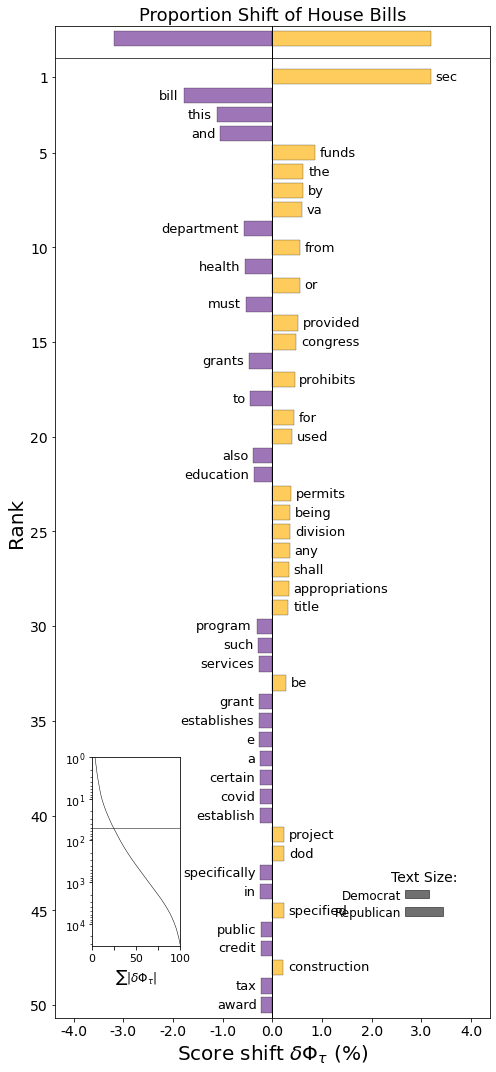

In [8]:
proportion_shift = sh.ProportionShift(type2freq_1=dem2count,
                                      type2freq_2=rep2count)
proportion_shift.get_shift_graph(system_names = ['Democrat', 'Republican'],
                                 title='Proportion Shift of House Bills')
plt.show();

The above graph shows the relative frequency of word $p^{(1)}_i$ in the first text, and $p^{(2)}_i$ is the relative frequency in the second text. Then calculates the proportion shift as $\delta p_i = p^{(2)}_i - p^{(1)}_i$. Words with $\delta p_i > 0$ are relatively more common in the second text and $\delta p_i < 0$ means that it is relatively more common in the first text. 

We can next look at the Shannn entropy, which can help identify more 'surprising' words.

/home/mitch/miniconda3/envs/ml/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


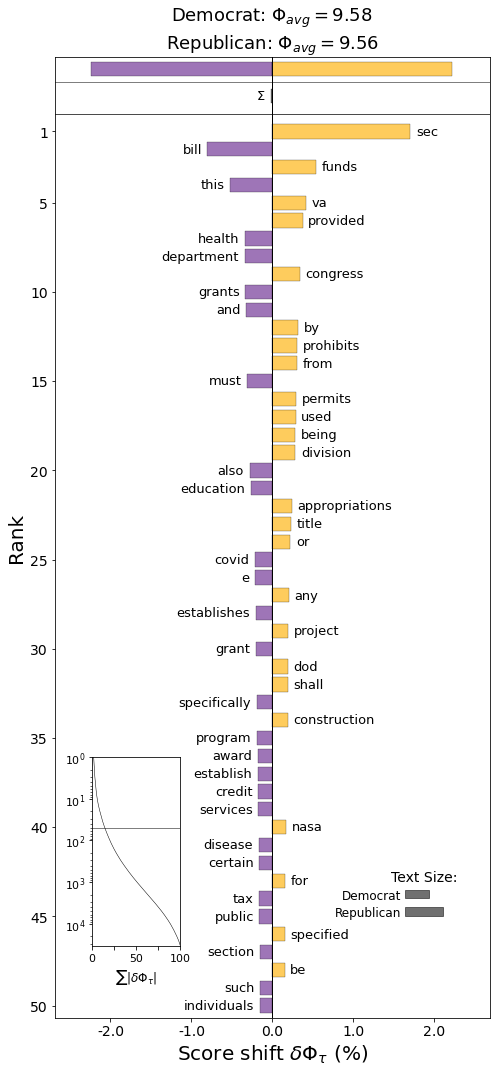

In [9]:
entropy_shift = sh.EntropyShift(type2freq_1=dem2count,
                                type2freq_2=rep2count,
                                base=2)
entropy_shift.get_shift_graph(system_names = ['Democrat', 'Republican'])
plt.show();

We can see here that there are a lot of stop words, words that don't contain much information in them like 'the', 'to', and 'of'. We'll use nltk's list of stopwords along with words that we feel don't contain information within the congressional setting, and remove them from our corpora.

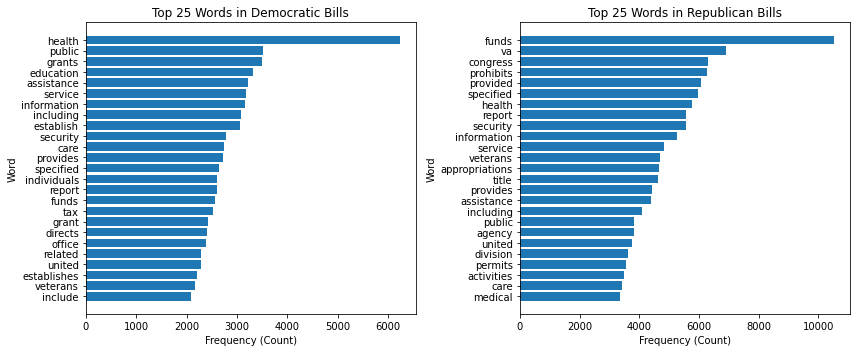

In [10]:
# Create stopwords
stop_words = stopwords.words('english')
additional_stopwords = ['bill',
                        'must',
                        'department',
                        'program',
                        'act',
                        'federal',
                        'shall',
                        'requires',
                        'requirements',
                        'services',
                        'may',
                        'certain',
                        'state',
                        'states',
                        'national',
                        'programs',
                        'provide',
                        'amends',
                        'also',
                        'u',
                        'sec',
                        'use',
                        'used',
                        'i', 'e']
for word in additional_stopwords:
    stop_words.append(word)

# Filter words out of corpora if 
dem_count = [word for word in dem_count if word[0] not in stop_words]
rep_count = [word for word in rep_count if word[0] not in stop_words]

# Extract the word, frequency pairs
dx, dy = zip(*dem_count[:25])
rx, ry = zip(*rep_count[:25])

# Plot most frequent words in bills proposed by democrats
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Top 25 Words in Democratic Bills')
plt.ylabel('Word')
plt.xlabel('Frequency (Count)')
plt.barh(dx[::-1], dy[::-1])

# Plot most frequent words in bills proposed by republicans
plt.subplot(1,2,2)
plt.title('Top 25 Words in Republican Bills')
plt.ylabel('Word')
plt.xlabel('Frequency (Count)')
plt.barh(rx[::-1], ry[::-1])

plt.tight_layout()
plt.show();

/home/mitch/miniconda3/envs/ml/lib/python3.9/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


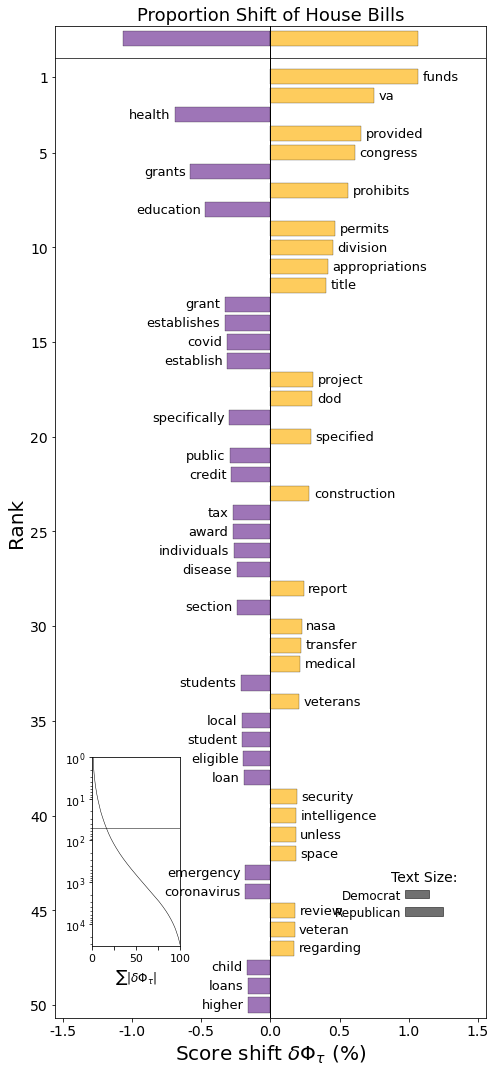

In [11]:
# Convert democrat words to dictionary of frequency counts
key,value = zip(*dem_count)
dem2count = {k:v for k,v in zip(key, value)}

# Convert republican words to dictionary of frequency counts
key,value = zip(*rep_count)
rep2count = {k:v for k,v in zip(key, value)}

# Plot proportional shift with stopwords removed
proportion_shift = sh.ProportionShift(type2freq_1=dem2count,
                                      type2freq_2=rep2count)
proportion_shift.get_shift_graph(system_names = ['Democrat', 'Republican'],
                                 title='Proportion Shift of House Bills')
plt.show();

We can see now some really interesting patterns, like how words 'health' and 'education' have a strong tendency to be part of democratic legislation, whereas 'funds', 'prohibits' are part of republican legislation.

Now that we've gotten a little understanding of the data, let's begin our analysis.

# Bag-of-Words
We'll begin by using a bag-of-words approach. By performing an 80/20 split on our data, we'll train a logistic regression, decision tree, random forest, support vector classifier, and multinomial naive bayes model to our data and compare the results.

In [12]:
# Extract just the sponsor party and bill summaries
df = congress[['sponsor_party', 'bill_summary']].copy()

# Remove Libertarian and Independents
df = df[df['sponsor_party'] != 'L']
df = df[df['sponsor_party'] != 'I']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['bill_summary'], df['sponsor_party'], random_state=0, test_size=0.8)

We will create three vectorizers, one that looks only at unigrams, the next will look at unigrams and bigrams, and the third will look at unigrams, bigrams, and trigrams. For details on how to use the `min_df` and `max_df` parameters see [this](https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer). We decided that setting a max_df to 0.95 would help remove corpus specific stop words and min_df was set to try and ignot particularly obscure words.

### Logistic Regression

In [82]:
# Create pipeline
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression()),
])

# Set parameter ranges for grid search
pipeline_params_lr = {
    'tfidf__max_features': [None, 1000],
    'tfidf__min_df': [2,3,4,5],
    'tfidf__max_df': [0.3,0.5,0.7],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__stop_words': [None, stop_words],
    'lr__penalty': ['l2']
}

# Initialize grid search
grid_search_lr = GridSearchCV(pipeline_lr, pipeline_params_lr, cv=5, n_jobs=-1)

# Fit grid search
grid_search_lr.fit(X_train, y_train)

# Print outputs
print(f'Best Score: {grid_search.best_score_}')
for i in list(pipeline_params_lr.keys()):
    if 'words' in i:
        print(f"{i}: stop_words", end=', ')
    else:
        print(f"{i}: {grid_search.best_params_[i]}", end=', ')
print("")
print(f'Train Accuracy Score: {grid_search.score(X_train,y_train)}')
print(f'Test Accuracy Score: {grid_search.score(X_test,y_test)}')

Best Score: 0.6820267686424474
tfidf__max_features: None, tfidf__min_df: 2, tfidf__max_df: 0.3, tfidf__ngram_range: (1, 3), tfidf__stop_words: stop_words, lr__penalty: l2, Train Accuracy Score: 0.8904397705544933
Test Accuracy Score: 0.6937048898236222


From here we cqn see that the best parameters from the grid search are
- tfidf__max_features: None
- tfidf__min_df: 2
- tfidf__max_df: 0.3
- tfidf__ngram_range: (1, 3)
- tfidf__stop_words: stop_words
- lr__penalty: l2

In [100]:
vectorizer_lr = TfidfVectorizer(strip_accents='unicode', 
                             lowercase=True,
                             max_features=None,
                             min_df=2,
                             max_df=0.3,
                             stop_words=stop_words, 
                             ngram_range=(1,3))

# Initialize logistic regression classifier
lr_clf = LogisticRegression(penalty='l2')

# Vectorize X data
X_train_vec_lr = vectorizer_lr.fit_transform(X_train)
X_test_vec_lr = vectorizer_lr.transform(X_test)

# Train classifier
lr_clf.fit(X_train_vec, y_train)

# Predict on test data
y_pred_lr = lr_clf.predict(X_test_vec)

# # Get accuracy score
accuracy_score(y_test, y_pred_lr)

0.6937048898236222

Here we can see that using a logistic regression model with l2 regularization we achieved an accuracy of 69.37% on our test data.

### Naive Bayes

For Naive bayes we'll perform a grid search to find optimal model parameters and then train our model.

In [88]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Set parameter ranges for grid search
pipeline_params_nb = {
    'tfidf__max_features': [None, 1000],
    'tfidf__min_df': [2,3,4,5],
    'tfidf__max_df': [0.1,0.2, 0.3,0.5],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__stop_words': [None, stop_words]
}

# Initialize grid search
grid_search_nb = GridSearchCV(pipeline_nb, pipeline_params_nb, cv=5, n_jobs=-1)

# Fit grid search
grid_search_nb.fit(X_train, y_train)

# Print outputs
print(f'Best Score: {grid_search_nb.best_score_}')
for i in list(pipeline_params_nb.keys()):
    if 'words' in i:
        print(f"{i}: stop_words", end=', ')
    else:
        print(f"{i}: {grid_search_nb.best_params_[i]}", end=', ')
print("")
print(f'Train Accuracy Score: {grid_search_nb.score(X_train,y_train)}')
print(f'Test Accuracy Score: {grid_search_nb.score(X_test,y_test)}')

Best Score: 0.6711281070745697
tfidf__max_features: None, tfidf__min_df: 5, tfidf__max_df: 0.2, tfidf__ngram_range: (1, 2), tfidf__stop_words: stop_words, 
Train Accuracy Score: 0.8166347992351817
Test Accuracy Score: 0.6782658572725969


In [89]:
vectorizer_nb = TfidfVectorizer(strip_accents='unicode',
                                lowercase=True,
                                max_features=None,
                                min_df=5,
                                max_df=0.2,
                                stop_words=stop_words,
                                ngram_range=(1,2))

# Initialize logistic regression classifier
nb_clf = MultinomialNB()

# Vectorize X data
X_train_vec_nb = vectorizer_nb.fit_transform(X_train)
X_test_vec_nb = vectorizer_nb.transform(X_test)

# Train classifier
nb_clf.fit(X_train_vec_nb, y_train)

# Predict on test data
y_pred_nb = nb_clf.predict(X_test_vec_nb)

# # Get accuracy score
accuracy_score(y_test, y_pred_nb)

0.64781798193203

Somewhat surprisingling, we achieved a lower score with Naive Bayes than with logistic regression. With an accuracy of just 64.78%

### Support Vector Classification (SVC)

In [92]:
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC()),
])

# Set parameter ranges for grid search
pipeline_params_svc = {
    'tfidf__max_features': [None, 1000],
    'tfidf__min_df': [2,3,4,5],
    'tfidf__max_df': [0.1,0.2, 0.3,0.5],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__stop_words': [None, stop_words]
}

# Initialize grid search
grid_search_svc = GridSearchCV(pipeline_svc, pipeline_params_svc, cv=5, n_jobs=-1)

# Fit grid search
grid_search_svc.fit(X_train, y_train)

# Print outputs
print(f'Best Score: {grid_search_svc.best_score_}')
for i in list(pipeline_params_svc.keys()):
    if 'words' in i:
        print(f"{i}: stop_words", end=', ')
    else:
        print(f"{i}: {grid_search_svc.best_params_[i]}", end=', ')
print("")
print(f'Train Accuracy Score: {grid_search_svc.score(X_train, y_train)}')
print(f'Test Accuracy Score: {grid_search_svc.score(X_test, y_test)}')

Best Score: 0.6887189292543021
tfidf__max_features: None, tfidf__min_df: 4, tfidf__max_df: 0.1, tfidf__ngram_range: (1, 2), tfidf__stop_words: stop_words, 
Train Accuracy Score: 0.9810707456978968
Test Accuracy Score: 0.7076621576406481


In [95]:
vectorizer_svc = TfidfVectorizer(strip_accents='unicode',
                                 lowercase=True,
                                 max_features=None,
                                 min_df=4,
                                 max_df=0.1,
                                 stop_words=stop_words,
                                 ngram_range=(1,2))

# Initialize logistic regression classifier
svc_clf = SVC(probability=True)

# Vectorize X data
X_train_vec_svc = vectorizer_svc.fit_transform(X_train)
X_test_vec_svc = vectorizer_svc.transform(X_test)

# Train classifier
svc_clf.fit(X_train_vec_svc, y_train)

# Predict on test data
y_pred_svc = svc_clf.predict(X_test_vec_svc)

# # Get accuracy score
accuracy_score(y_test, y_pred_svc)

0.7041728406863916

Here we can see our best result yet! An accuracy score of 70%, while not a huge improvement over logistic regression, it is still satisfying to be in the 70s.

### Random Forest

# ROC Curves

In [128]:
# Calculate the probabilities
y_probs_lr = cross_val_predict(lr_clf, X_test_vec_lr, y_test, cv=3, method="predict_proba", n_jobs=-1)
y_probs_nb = cross_val_predict(nb_clf, X_test_vec_nb, y_test, cv=3, method="predict_proba", n_jobs=-1)
y_probs_svc = cross_val_predict(svc_clf, X_test_vec_svc, y_test, cv=3, method="predict_proba", n_jobs=-1)
# y_probs_rf = cross_val_predict(rf_clf, X_train_lr, y_train, cv=3, method="predict_proba")

In [132]:
# Get the probability of the positive class as the score
y_scores_lr = [i[1] for i in y_probs_lr]
y_scores_nb = [i[1] for i in y_probs_nb]
y_scores_svc = [i[1] for i in y_probs_svc]
# y_scores_rf = y_probs_rf[:1]

In [135]:
# Remap y values to numeric
y_test_num = y_test.replace({'D':0, 'R':1})

# Get random guess for baseline
r_probs = np.zeros(len(y_test))

# Calculate values to plot ROC curve
fpr_random, tpr_random, _ = roc_curve(y_test_num, r_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test_num, y_scores_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test_num, y_scores_nb)
fpr_svc, tpr_svc, _ = roc_curve(y_test_num, y_scores_svc)

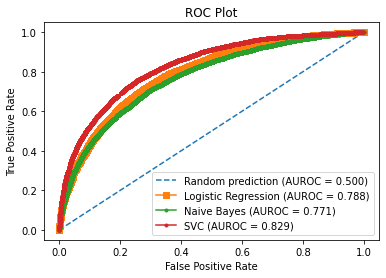

In [143]:
# Get AUROC scores
r_auc = roc_auc_score(y_test_num, r_probs)
lr_auc = roc_auc_score(y_test_num, y_scores_lr)
nb_auc = roc_auc_score(y_test_num, y_scores_nb)
svc_auc = roc_auc_score(y_test_num, y_scores_svc)

# Calculate values to plot ROC curve
fpr_r, tpr_r, _ = roc_curve(y_test_num, random_guess)
fpr_lr, tpr_lr, _ = roc_curve(y_test_num, y_scores_lr)
fpr_nb, tpr_nb, _ = roc_curve(y_test_num, y_scores_nb)
fpr_svc, tpr_svc, _ = roc_curve(y_test_num, y_scores_svc)

# Plot
plt.plot(fpr_r, tpr_r, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(fpr_lr, tpr_lr, marker='s', label='Logistic Regression (AUROC = %0.3f)' % lr_auc)
plt.plot(fpr_nb, tpr_nb, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(fpr_svc, tpr_svc, marker='.', label='SVC (AUROC = %0.3f)' % svc_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('ROC.png')
plt.show()